In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [20]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import PolynomialFeatures
# from catboost import CatBoostRegressor
# import xgboost as xg 

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
# df.head()

In [5]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
# df_test.head()

In [ ]:
df.info()

In [ ]:
df.describe().round(1)

In [ ]:
# plt.plot(df['Age'].sort_values().reset_index(drop=True))

non_object_columns = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

for non_object_column in non_object_columns:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.distplot(a=df[non_object_column])
    plt.subplot(1, 2, 2)
    sns.distplot(a=df_test[non_object_column])
    # plt.title(non_object_column)
    plt.show()

In [ ]:
df.isna().sum().sort_values(ascending=False)

In [ ]:
df_dropna = df.dropna().reset_index()

non_object_columns = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

for non_object_column in non_object_columns:
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    sns.distplot(a=df[non_object_column])
    
    plt.subplot(1, 3, 2)
    sns.distplot(a=df_test[non_object_column])
    
    plt.subplot(1, 3, 3)
    sns.distplot(a=df_dropna[non_object_column])
    
    plt.show()

In [ ]:
# Previous Claims         364029 ------------- mean of above and below
# Occupation              358075 ------------- check test and train data
# Credit Score            137882 ------------- mean of above and below
# Number of Dependents    109672 ------------- mean of above and below
# Customer Feedback        77824 ------------- check test and train data
# Health Score             74076 ------------- mean of above and below
# Annual Income            44949 ------------- mean of above and below
# Age                      18705 ------------- mean of above and below
# Marital Status           18529 ------------- check test and train data
# Vehicle Age                  6 ------------- mean of above and below
# Insurance Duration           1 ------------- mode

In [ ]:
print(df.shape)
print(df_dropna.shape)
print(df_test.shape)

In [6]:
df1 = df.copy()
print(df1.shape)
# df1.head()

(1200000, 21)


In [7]:
df1.drop(['id', 'Policy Start Date'], axis=1, inplace=True)

In [ ]:
df1['Occupation'].unique()

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
df1['Occupation'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(1, 2, 2)
df_test['Occupation'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.show()

In [ ]:
(df1.groupby('Occupation', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)

In [ ]:
df1['Customer Feedback'].unique()

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
df1['Customer Feedback'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(1, 2, 2)
df_test['Customer Feedback'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.show()

In [ ]:
(df1.groupby('Customer Feedback', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)

In [ ]:
df1[df1['Customer Feedback'].isna()]['Premium Amount']

In [ ]:
plt.subplot(2, 2, 1)
sns.distplot(a=(df1[df1['Customer Feedback'] == 'Average']['Premium Amount']))

plt.subplot(2, 2, 2)
sns.distplot(a=(df1[df1['Customer Feedback'] == 'Good']['Premium Amount']))

plt.subplot(2, 2, 3)
sns.distplot(a=(df1[df1['Customer Feedback'] == 'Poor']['Premium Amount']))

plt.subplot(2, 2, 4)
sns.distplot(a=(df1[df1['Customer Feedback'].isna()]['Premium Amount']))

In [ ]:
plt.boxplot(df1[df1['Customer Feedback'].isna()]['Premium Amount'])

In [ ]:
df1[df1['Customer Feedback'].isna()].isna().sum().sort_values(ascending=False)

In [ ]:
df1['Customer Feedback'].isna().sum()

In [ ]:
df1['Marital Status'].unique()

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
df1['Marital Status'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(1, 2, 2)
df_test['Marital Status'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.show()

In [ ]:
(df1.groupby('Marital Status', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)

In [ ]:
plt.subplot(2, 2, 1)
sns.distplot(a=(df1[df1['Marital Status'] == 'Divorced']['Premium Amount']))

plt.subplot(2, 2, 2)
sns.distplot(a=(df1[df1['Marital Status'] == 'Married']['Premium Amount']))

plt.subplot(2, 2, 3)
sns.distplot(a=(df1[df1['Marital Status'] == 'Single']['Premium Amount']))

plt.subplot(2, 2, 4)
sns.distplot(a=(df1[df1['Marital Status'].isna()]['Premium Amount']))

In [ ]:
df1[df1['Customer Feedback'].isna() | df1['Marital Status'].isna()].isna().sum().sort_values(ascending=False)

In [ ]:
df1.dropna(subset=['Customer Feedback','Marital Status'], inplace=True)
df1 = df1.reset_index().drop(['index', 'id'], axis=1)
df1

In [ ]:
plt.figure(figsize=(7, 8))
plt.subplot(2, 1, 1)
df1['Occupation'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(2, 1, 2)
(df1.groupby('Occupation', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)
plt.show()

In [ ]:
df1.isna().sum().sort_values(ascending=False)

In [ ]:
df1.select_dtypes("object")

In [ ]:
for i in df1.select_dtypes("object").columns:
    print(i, " "*(20-len(i)),df1[i].unique(), "\n")

In [ ]:
# Gender                     0 --------- 0 1
# Marital Status             0 --------- 0 1 OHE
# Education Level            0 --------- 0 1 OHE
# Occupation            329843 --------- 0 1 OHE
# Location                   0 --------- 0 1 OHE
# Policy Type                0 --------- -1 0 1
# Policy Start Date          0 --------- drop
# Customer Feedback          0 --------- -1 0 1
# Smoking Status             0 --------- 0 1
# Exercise Frequency         0 --------- 1 7 30
# Property Type              0 --------- 0 1 OHE

In [8]:
gender_dict = {'Female': 0,'Male': 1}
policy_type_dict = {'Basic': -1,'Premium': 0,'Comprehensive': 1}
# customer_feedback_dict = {'Poor': -1,'Average': 0,'Good': 1}
smoking_status_dict = {'No': 0,'Yes': 1}
# exercise_frequency_dict = {'Rarely': 1, 'Daily':0, 'Weekly':1/7, 'Monthly': 1/30}

In [9]:
df1['Gender'] = df1['Gender'].map(gender_dict)
df1['Policy Type'] = df1['Policy Type'].map(policy_type_dict)
# df1['Customer Feedback'] = df1['Customer Feedback'].map(customer_feedback_dict)
df1['Smoking Status'] = df1['Smoking Status'].map(smoking_status_dict)
# df1['Exercise Frequency'] = df1['Exercise Frequency'].map(exercise_frequency_dict)

In [ ]:
pd.get_dummies(df1['Customer Feedback'], dtype = int)

In [ ]:
pd.get_dummies(df1['Marital Status'], dtype = int)

In [ ]:
pd.get_dummies(df1['Education Level'], dtype = int).drop(['PhD'], axis=1)

In [ ]:
pd.get_dummies(df1['Occupation'], dtype = int)

In [ ]:
pd.get_dummies(df1['Location'], dtype = int).drop(['Suburban'], axis=1)

In [ ]:
pd.get_dummies(df1['Property Type'], dtype = int).drop(['Condo'], axis=1)

In [ ]:
df1.drop(['Policy Start Date'], axis=1, inplace=True)
df1

In [10]:
df2 = pd.concat(
    [
        df1.select_dtypes(exclude = "object"),
        pd.get_dummies(df1['Marital Status'], dtype = int),
        pd.get_dummies(df1['Education Level'], dtype = int).drop(['PhD'], axis=1),
        pd.get_dummies(df1['Occupation'], dtype = int),
        pd.get_dummies(df1['Location'], dtype = int).drop(['Suburban'], axis=1),
        pd.get_dummies(df1['Property Type'], dtype = int).drop(['Condo'], axis=1),
        pd.get_dummies(df1['Customer Feedback'], dtype = int),
        pd.get_dummies(df1['Exercise Frequency'], dtype = int).drop(['Rarely'], axis=1)     
    ],
    axis = "columns"
)
# df2

In [ ]:
df2.isna().sum().sort_values(ascending=False)

In [ ]:
def fill_nan_with_neighbors(series):
    for i in range(1, len(series) - 1):
        if pd.isna(series.iloc[i]):
            prev_value = series.iloc[i - 1]
            next_value = series.iloc[i + 1]
            if not pd.isna(prev_value) and not pd.isna(next_value):
                series.iloc[i] = (prev_value + next_value) / 2
    return series

In [ ]:
# Previous Claims         364029 ------------- mean of above and below
# Occupation              358075 ------------- check test and train data
# Credit Score            137882 ------------- mean of above and below
# Number of Dependents    109672 ------------- mean of above and below
# Customer Feedback        77824 ------------- check test and train data
# Health Score             74076 ------------- mean of above and below
# Annual Income            44949 ------------- mean of above and below
# Age                      18705 ------------- mean of above and below
# Marital Status           18529 ------------- check test and train data
# Vehicle Age                  6 ------------- mean of above and below
# Insurance Duration           1 ------------- mode

In [ ]:
df2['Previous Claims'] = fill_nan_with_neighbors(df2['Previous Claims'])
df2['Credit Score'] = fill_nan_with_neighbors(df2['Credit Score'])
df2['Number of Dependents'] = fill_nan_with_neighbors(df2['Number of Dependents'])
df2['Health Score'] = fill_nan_with_neighbors(df2['Health Score'])
df2['Annual Income'] = fill_nan_with_neighbors(df2['Annual Income'])
df2['Age'] = fill_nan_with_neighbors(df2['Age'])
df2['Vehicle Age'].fillna(df2['Vehicle Age'].mean(), inplace=True)
df2['Insurance Duration'].fillna(df2['Insurance Duration'].mode()[0], inplace=True)

In [11]:
df2.fillna(df2.mean().to_dict(), inplace=True)

In [12]:
df2

,Age,Gender,Annual Income,Number of Dependents,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,...,Rural,Urban,Apartment,House,Average,Good,Poor,Daily,Monthly,Weekly
0,19.0,0,10049.000000,1.000000,22.598761,0,2.000000,17.0,372.00000,5.0,...,0,1,0,1,0,0,1,0,0,1
1,39.0,0,31678.000000,3.000000,15.569731,1,1.000000,12.0,694.00000,2.0,...,1,0,0,1,1,0,0,0,1,0
2,23.0,1,25602.000000,3.000000,47.177549,0,1.000000,14.0,592.92435,3.0,...,0,0,0,1,0,1,0,0,0,1
3,21.0,1,141855.000000,2.000000,10.938144,-1,1.000000,0.0,367.00000,1.0,...,1,0,1,0,0,0,1,1,0,0
4,21.0,1,39651.000000,1.000000,20.376094,0,0.000000,8.0,598.00000,4.0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,0,27316.000000,0.000000,13.772907,0,1.002689,5.0,372.00000,3.0,...,0,1,1,0,0,0,1,1,0,0
1199996,54.0,1,35786.000000,2.009934,11.483482,1,1.002689,10.0,597.00000,4.0,...,1,0,1,0,0,0,1,0,0,1
1199997,19.0,1,51884.000000,0.000000,14.724469,-1,0.000000,19.0,592.92435,6.0,...,0,0,0,0,0,1,0,0,1,0
1199998,55.0,1,32745.217777,1.000000,18.547381,0,1.000000,7.0,407.00000,4.0,...,0,0,1,0,0,0,1,1,0,0


In [ ]:
df2.hist(figsize = (15,15))

In [13]:
df2.isna().sum()

Age                     0
Gender                  0
Annual Income           0
Number of Dependents    0
Health Score            0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Smoking Status          0
Premium Amount          0
Divorced                0
Married                 0
Single                  0
Bachelor's              0
High School             0
Master's                0
Employed                0
Self-Employed           0
Unemployed              0
Rural                   0
Urban                   0
Apartment               0
House                   0
Average                 0
Good                    0
Poor                    0
Daily                   0
Monthly                 0
Weekly                  0
dtype: int64

In [12]:
df2.to_csv("train_new.csv", index=False)

In [22]:
df2 = pd.read_csv('/kaggle/working/train_new.csv')

In [94]:
df2.shape

(1200000, 31)

In [24]:
df2.isna().sum()

Age                     0
Gender                  0
Annual Income           0
Number of Dependents    0
Health Score            0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Smoking Status          0
Premium Amount          0
Divorced                0
Married                 0
Single                  0
Bachelor's              0
High School             0
Master's                0
Employed                0
Self-Employed           0
Unemployed              0
Rural                   0
Urban                   0
Apartment               0
House                   0
Average                 0
Good                    0
Poor                    0
Daily                   0
Monthly                 0
Weekly                  0
dtype: int64

In [ ]:
sns.heatmap(df.isna().sort_values(by=["Occupation"]) == True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    print(df[non_object_column].mean())

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'id':
        print(df[non_object_column].mode()[0])

In [ ]:
df['Age'].mode()[0]

In [ ]:
# df.dropna(inplace = True)
for non_object_column in df.select_dtypes(exclude = "object").columns:
    df[non_object_column].fillna(df[non_object_column].mode()[0], inplace = True)

df.dropna(inplace = True)

In [ ]:
df.shape

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot = True, cmap = "Reds")

In [ ]:
df_categorical = df.select_dtypes('object')
for object_column in df_categorical.columns:
    print(object_column, {df[object_column].nunique()}, ': ', df[object_column].unique(), '\n')

In [ ]:
df.drop(['id', 'Policy Start Date'], axis = 1, inplace = True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'Premium Amount':
        df[non_object_column] = df[non_object_column] / df[non_object_column].max()

In [ ]:
df.head()

In [ ]:
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"].apply(lambda x: x[:10]))

In [ ]:
pd.get_dummies(df_categorical, drop_first = True, dtype = int)

In [ ]:
df = pd.concat(
    [
        df.select_dtypes(exclude = "object"), 
        pd.get_dummies(df.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)
df.head()

In [ ]:
df.to_csv("train_new.csv", index=False)

In [ ]:
df = pd.read_csv("/kaggle/working/train_new.csv")

In [ ]:
df.dtypes

In [ ]:
df.describe()

In [ ]:
plt.boxplot(df['Premium Amount'])

In [ ]:
plt.boxplot(df['Annual Income'])

In [ ]:
plt.boxplot(df['Previous Claims'])

In [ ]:
df[df['Previous Claims'] > 2]['Age'].count()

In [ ]:
df[df['Annual Income'] > 100_000]['Age'].count()

In [ ]:
df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3000)]['Age'].count()

In [ ]:
df['Age'].count()

In [ ]:
df2 = df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3_000)]
df2['Age'].count()

In [ ]:
df = df[(df['Previous Claims'] <= 5) & (df['Annual Income'] <= 100_000) & (df['Premium Amount'] <= 3000)]
df['Age'].count()

In [76]:
df = df2.copy()
y = df['Premium Amount']
for column in df.columns: 
    df[column] = (df[column]  / df[column].abs().max()).round(3)
x = df.drop(['Premium Amount'], axis = 1)


In [ ]:
for column in x.columns: 
    x[column] = x[column]  / x[column].abs().max()

In [77]:
y

0          2869.0
1          1483.0
2           567.0
3           765.0
4          2022.0
            ...  
1199995    1303.0
1199996     821.0
1199997     371.0
1199998     596.0
1199999    2480.0
Name: Premium Amount, Length: 1200000, dtype: float64

In [78]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [ ]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=10, max_depth=30, random_state=0)
model3 = PolynomialFeatures(degree=4)
model4 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 7,
                            n_estimators = 1000,
                            verbose = False
)
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 7,
                            n_estimators = 1000,
                            verbose = False
)
model5 = xg.XGBRegressor(
    objective ='reg:linear', 
    n_estimators = 1200, 
    # seed = 123,
    max_depth=10, 
    # eta=0.01,
    learning_rate=0.01
) 

In [79]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(300, kernel_initializer='normal',input_dim = x.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mean_squared_logarithmic_error'])
NN_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 300)                 │           9,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,381 (466.33 KB)

 Trainable params: 119,381 (466.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x_train = model3.fit_transform(x_train)
x_test = model3.fit_transform(x_test)
x = model3.fit_transform(x)

In [80]:
# model = model3
# model.fit(model3.fit_transform(x_train))

# model = model1
# model.fit(model3.fit(model3.fit_transform(x_train)), y_train)

model = NN_model
model.fit(x_train, y_train)

30000/30000 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - loss: 1.4325 - mean_squared_logarithmic_error: 1.4325


In [81]:
y_pred = model.predict(x_test).round(3)

7500/7500 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


In [44]:
y_test

209886     0.088
599970     0.094
1108534    0.111
613145     0.164
216834     0.288
           ...  
1128537    0.145
923564     0.112
248631     0.251
114240     0.317
252069     0.103
Name: Premium Amount, Length: 240000, dtype: float64

In [82]:
y_pred = pd.Series(np.array(y_pred).flatten(), index=y_test.index)
y_pred

209886     918.698975
599970     795.479980
1108534    776.135986
613145     781.565002
216834     847.593018
              ...    
1128537    741.468994
923564     927.151978
248631     794.643005
114240     638.252014
252069     802.223022
Length: 240000, dtype: float32

In [45]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

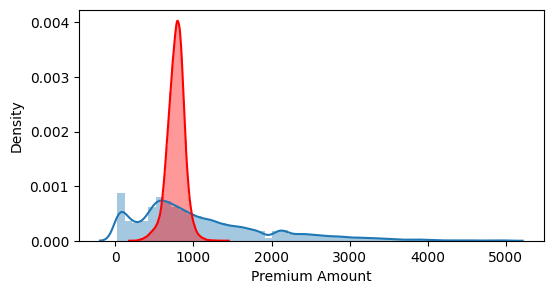

In [83]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# sns.distplot(a=y_pred, ax=ax1)
# sns.distplot(a=y_test, ax=ax2)
# plt.show()


fig, ax = plt.subplots(figsize=(6, 3))
sns.distplot(a=y_test, ax=ax)
sns.distplot(a=y_pred, color="red", ax=ax)
plt.show()

In [86]:
df_pred = pd.DataFrame([y_pred*4999, y_test*4999]).transpose()
df_pred = df_pred.describe()
df_pred['diff'] = df_pred[0] - df_pred[1]
df_pred['0/1'] = df_pred[0] / df_pred[1]
df_pred

KeyError: 0

In [84]:
rmsle(y_pred, y_test)

1.0853905227711151

In [ ]:
y_pred

In [ ]:
y_pred/y_pred.max()

In [88]:
rmsle(y_pred*4999-600, y_test*4999)

1.0914514114303078

Minimum RMSLE: 1.0913957640811258
5000


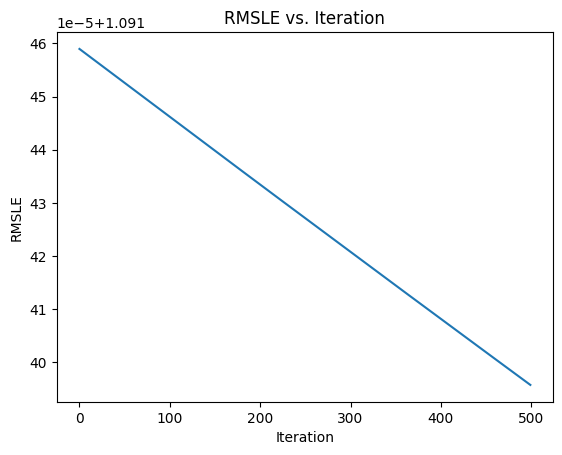

In [92]:
import matplotlib.pyplot as plt

list_ = []
min_ = 0  # Rename variable to avoid overwriting Python's built-in `min`
a = 0

# Loop through the range
for i in range(10, 5001, 10):
    current_rmsle = rmsle(y_pred * 4999 - i, y_test * 4999)  # Calculate RMSLE
    list_.append(current_rmsle)  # Append current RMSLE to the list

    # Check if this RMSLE is smaller than the current minimum
    if len(list_) == 1 or current_rmsle < list_[min_]:
        min_ = len(list_) - 1  # Update `min_` to the index of the smallest value
        a = i

# Output the minimum RMSLE
print("Minimum RMSLE:", list_[min_])
print(a)

# Plot the list of RMSLE values
plt.plot(list_)
plt.xlabel("Iteration")
plt.ylabel("RMSLE")
plt.title("RMSLE vs. Iteration")
plt.show()


In [ ]:
1.0791089458874077

In [ ]:
df2['Premium Amount'].max()

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.distplot(a=df_pred['value'])

plt.subplot(1, 2, 2)
sns.distplot(a=y_test)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), sharey=True)
plt.subplot(1, 2, 1)
plt.plot(df_pred[0][:1000])
plt.subplot(1, 2, 2)
plt.plot(df_pred[1][:1000])

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.distplot(a=y_pred-10)
plt.subplot(1, 2, 2)
sns.distplot(a=y_test)
plt.show()

In [95]:
model = NN_model
model.fit(x, y)

37500/37500 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - loss: 1.1745 - mean_squared_logarithmic_error: 1.1745


In [96]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

df_test['Gender'] = df_test['Gender'].map(gender_dict)
df_test['Policy Type'] = df_test['Policy Type'].map(policy_type_dict)
# df_test['Customer Feedback'] = df_test['Customer Feedback'].map(customer_feedback_dict)
df_test['Smoking Status'] = df_test['Smoking Status'].map(smoking_status_dict)
# df_test['Exercise Frequency'] = df_test['Exercise Frequency'].map(exercise_frequency_dict)

df_test.drop(['Policy Start Date', 'id'], axis=1, inplace=True)

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"),
        pd.get_dummies(df_test['Marital Status'], dtype = int),
        pd.get_dummies(df_test['Education Level'], dtype = int).drop(['PhD'], axis=1),
        pd.get_dummies(df_test['Occupation'], dtype = int),
        pd.get_dummies(df_test['Location'], dtype = int).drop(['Suburban'], axis=1),
        pd.get_dummies(df_test['Property Type'], dtype = int).drop(['Condo'], axis=1),
        pd.get_dummies(df_test['Customer Feedback'], dtype = int),
        pd.get_dummies(df_test['Exercise Frequency'], dtype = int).drop(['Rarely'], axis=1)   
    ],
    axis = "columns"
)

for column in df_test.columns: 
    df_test[column] = (df_test[column]  / df_test[column].abs().max()).round(3)

df_test.fillna(df_test.mean().to_dict(), inplace=True)

# df_test.isna().sum()

Y_pred_test = model.predict(df_test)

25000/25000 ━━━━━━━━━━━━━━━━━━━━ 34s 1ms/step


In [97]:
df_test.shape

(800000, 30)

In [ ]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

# for non_object_column in df_test.select_dtypes(exclude = "object").columns:
#     df_test[non_object_column] = df_test[non_object_column] / df_test[non_object_column].max()

for non_object_column in df_test.select_dtypes(exclude = "object").columns:
    df_test[non_object_column].fillna(df_test[non_object_column].mean(), inplace = True)

df_test["Policy Start Date"] = pd.to_datetime(df_test["Policy Start Date"].apply(lambda x: x[:10]))

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"), 
        pd.get_dummies(df_test.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)

x_df_test = df_test.drop(['id', 'Policy Start Date'], axis = 1)

x2_df_test = x_df_test[(x_df_test['Previous Claims'] > 2) | (x_df_test['Annual Income'] > 100_000)]

# x_df_test = x_df_test[(x_df_test['Previous Claims'] <= 2) & (x_df_test['Annual Income'] <= 100_000)]

print(x_df_test.shape)
print(x2_df_test.shape)
x_df_test.head()

In [ ]:
df_test[(df_test['Previous Claims'] > 2) | (df_test['Annual Income'] > 100_000)]['Age'].count()

In [ ]:
Y_pred_test = model.predict(x_df_test)

In [ ]:
x2 = df2.drop(['Premium Amount'], axis = 1)
y2 = df2['Premium Amount']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 1)
model_2 = model4_2
model_2.fit(x2_train, y2_train)
y2_pred = model_2.predict(x2_test)

df2_pred = pd.DataFrame([y2_pred, y2_test]).transpose()
df2_pred = df2_pred.describe()
df2_pred['diff'] = df2_pred[0] - df2_pred[1]
df2_pred['0/1'] = df2_pred[0] / df2_pred[1]
df2_pred

In [ ]:
print(rmsle(y2_pred, y2_test))

In [ ]:
print(rmsle(y2_pred-401.5, y2_test))

In [ ]:
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 9,
                            n_estimators = 1000,
                            verbose = False
)
model_2 = model4_2
model_2.fit(x2, y2)

In [ ]:
Y2_pred_test = model_2.predict(x2_df_test)

In [ ]:
Y_pred_test.size + Y2_pred_test.size

In [98]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
df_sub.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [100]:
df_sub['Premium Amount'] = (Y_pred_test).round(3)
df_sub

,id,Premium Amount
0,1200000,848.403015
1,1200001,890.508972
2,1200002,833.934021
3,1200003,737.267029
4,1200004,827.372986
...,...,...
799995,1999995,942.646973
799996,1999996,486.662994
799997,1999997,669.984009
799998,1999998,714.617004


In [101]:
df_sub.to_csv("submissions1.csv", index=False)

In [ ]:
Y_pred_test = Y_pred_test - 100

# Y2_pred_test = Y2_pred_test - 401.5

In [ ]:
x_df_test['Prediction'] = Y_pred_test

x2_df_test['Prediction'] = Y2_pred_test

Y_pred_test_result = pd.concat([x_df_test, x2_df_test], axis = 'rows')['Prediction'].sort_index()

In [ ]:
Y_pred_test_result.size

In [ ]:
df_test['Premium Amount'] = Y_pred_test.round(3)
df_submission = df_test[['id', 'Premium Amount']]

print(df_submission.shape)
df_submission.head()

In [ ]:
df_submission.to_csv("submissions1.csv", index=False)

In [ ]:
df = df.sort_values(by='Premium Amount').reset_index(drop=True)
df

In [ ]:
plt.plot(df['Premium Amount'])